<a href="https://colab.research.google.com/github/stratoskar/Path-Based-Traffic-Flow-Prediction/blob/main/Python_Code/4_Why_SPQs_are_usefull%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is intended to assess the effectiveness of Strict Path Queries. Considering that one image represents 1000 data points, we will utilize plots to evaluate the actual impact they have when analyzing traffic flow data.

Note, the definition of the Strict Path Queries is [here](https://dl.acm.org/doi/abs/10.1145/2666310.2666413)

In [16]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Standard library imports
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Handle timestamps
from datetime import datetime, timedelta

In [17]:
# Access to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Compare the time series datasets**:

In this step, the following commands are executed:
- Load the two time series datasets that we generated using in the previous code file.
- Preprocess the datasets
- Visualize the aggregated traffic flow information per timestamp

In [18]:
# Read the two traffic flow datasets
traffic_flow_SPQ = pd.read_csv('/content/drive/MyDrive/Paper/Timeseries/traffic_flow_SPQ.csv',nrows=100)
traffic_flow_no_SPQ = pd.read_csv('/content/drive/MyDrive/Paper/Timeseries/traffic_flow_without_SPQ.csv')

In [19]:
# Print the traffic flow dataset made with SPQ rules
traffic_flow_SPQ.head(2)

,taxi_id,traj_id,path,length,"(Timestamp('2008-05-17 10:00:04'), Timestamp('2008-05-17 10:30:04'))","(Timestamp('2008-05-17 10:30:04'), Timestamp('2008-05-17 11:00:04'))","(Timestamp('2008-05-17 11:00:04'), Timestamp('2008-05-17 11:30:04'))","(Timestamp('2008-05-17 11:30:04'), Timestamp('2008-05-17 12:00:04'))","(Timestamp('2008-05-17 12:00:04'), Timestamp('2008-05-17 12:30:04'))","(Timestamp('2008-05-17 12:30:04'), Timestamp('2008-05-17 13:00:04'))",...,"(Timestamp('2008-06-10 04:30:04'), Timestamp('2008-06-10 05:00:04'))","(Timestamp('2008-06-10 05:00:04'), Timestamp('2008-06-10 05:30:04'))","(Timestamp('2008-06-10 05:30:04'), Timestamp('2008-06-10 06:00:04'))","(Timestamp('2008-06-10 06:00:04'), Timestamp('2008-06-10 06:30:04'))","(Timestamp('2008-06-10 06:30:04'), Timestamp('2008-06-10 07:00:04'))","(Timestamp('2008-06-10 07:00:04'), Timestamp('2008-06-10 07:30:04'))","(Timestamp('2008-06-10 07:30:04'), Timestamp('2008-06-10 08:00:04'))","(Timestamp('2008-06-10 08:00:04'), Timestamp('2008-06-10 08:30:04'))","(Timestamp('2008-06-10 08:30:04'), Timestamp('2008-06-10 09:00:04'))","(Timestamp('2008-06-10 09:00:04'), Timestamp('2008-06-10 09:30:04'))"
0,112,479,"[204965468, 204965468, 204965468, 204965468, 2...",11,17,9,8,6,5,2,...,1,0,0,0,0,2,1,1,1,0
1,378,1123,"[930108605, 236348363, 541597678, 202317708, 8...",18,1,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1


In [20]:
# Print the traffic flow dataset made without SPQ rules
traffic_flow_no_SPQ.head(2)

,taxi_id,traj_id,path,length,"(Timestamp('2008-05-17 10:00:04'), Timestamp('2008-05-17 10:30:04'))","(Timestamp('2008-05-17 10:30:04'), Timestamp('2008-05-17 11:00:04'))","(Timestamp('2008-05-17 11:00:04'), Timestamp('2008-05-17 11:30:04'))","(Timestamp('2008-05-17 11:30:04'), Timestamp('2008-05-17 12:00:04'))","(Timestamp('2008-05-17 12:00:04'), Timestamp('2008-05-17 12:30:04'))","(Timestamp('2008-05-17 12:30:04'), Timestamp('2008-05-17 13:00:04'))",...,"(Timestamp('2008-06-10 04:30:04'), Timestamp('2008-06-10 05:00:04'))","(Timestamp('2008-06-10 05:00:04'), Timestamp('2008-06-10 05:30:04'))","(Timestamp('2008-06-10 05:30:04'), Timestamp('2008-06-10 06:00:04'))","(Timestamp('2008-06-10 06:00:04'), Timestamp('2008-06-10 06:30:04'))","(Timestamp('2008-06-10 06:30:04'), Timestamp('2008-06-10 07:00:04'))","(Timestamp('2008-06-10 07:00:04'), Timestamp('2008-06-10 07:30:04'))","(Timestamp('2008-06-10 07:30:04'), Timestamp('2008-06-10 08:00:04'))","(Timestamp('2008-06-10 08:00:04'), Timestamp('2008-06-10 08:30:04'))","(Timestamp('2008-06-10 08:30:04'), Timestamp('2008-06-10 09:00:04'))","(Timestamp('2008-06-10 09:00:04'), Timestamp('2008-06-10 09:30:04'))"
0,112,479,"[204965468, 204965468, 204965468, 204965468, 2...",11,220,90,99,63,55,22,...,8,0,0,0,0,20,17,6,11,4
1,378,1123,"[930108605, 236348363, 541597678, 202317708, 8...",18,1,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1


**Change the names of time columns** in every time series dataset.

In [21]:
# This list contains the column names
columns = ["Taxi ID", "Traj ID", "Path", "Length"]

# Generate the columns of the datasets
i = 4
while(True):

    # If it's the first iteration, append the initial timestamp
    if i == 4:
        columns.append(pd.to_datetime('2008-05-17 10:00:04'))
    else:
        # Append the next timestamp by adding 30 minutes (1800 seconds) to the previous timestamp
        columns.append(columns[i-1] + timedelta(seconds=1800))

    # Check if the current timestamp is greater than or equal to a specific end timestamp
    if (columns[i] >= pd.to_datetime('2008-06-10 09:30:04')):

        # Break out of the loop if the condition is met
        break

    # Increment the counter
    i += 1

# Delete the last timestamp
columns.pop()

# Assign new column names to our dataframes
traffic_flow_SPQ.columns = columns
traffic_flow_no_SPQ.columns = columns

**Preprocess the time series datasets**
In this step, we are doing the following operations:
- Reshape them to long format using melt function
- Preprocess the data types of each column

In [22]:
# Define a function to categorize hours
def categorize_hour(hour):
    '''
    Categorizes an hour into different time periods of the day.
    Parameters:
    - hour (int): An integer representing the hour of the day (24-hour format).
    Returns:
    - str: A string indicating the time of day category ('Morning', 'Noon', 'Evening', 'Night').
    '''
    if 3 <= hour < 11:
        return 'Morning'
    elif 11 <= hour < 18:
        return 'Noon'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

In [23]:
# Define a list of columns that will be used as identifiers during the melt operation
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']

# Apply melt function to the first dataset ('traffic_flow_SPQ')
# Get the column names from the third column onwards as time_cols
time_cols = traffic_flow_SPQ.iloc[:,2:].columns

# We reshape the dataframe from wide format to long format,
# keeping the columns in id_cols as identifiers, and the rest of the columns in time_cols are melted into two new columns.
traffic_flow_SPQ = traffic_flow_SPQ.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')

# Convert the 'Time Column' to datetime format to handle time-related data
traffic_flow_SPQ['Time Column'] = pd.to_datetime(traffic_flow_SPQ['Time Column'])

# Sort rows by 'Path' and 'Time Column' for both datasets in ascending order
traffic_flow_SPQ = traffic_flow_SPQ.sort_values(by=['Path','Time Column']).reset_index(drop=True)

# Add new columns that derive from 'Time Column' column
traffic_flow_SPQ['hour'] = traffic_flow_SPQ['Time Column'].dt.hour # Extracting hour
traffic_flow_SPQ['month'] = traffic_flow_SPQ['Time Column'].dt.month # Extracting month
traffic_flow_SPQ['time_of_day'] = traffic_flow_SPQ['hour'].apply(categorize_hour) # Extract day time period

In [24]:
# Print 'traffic_flow_SPQ' dataframe
traffic_flow_SPQ.head(5)

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow,hour,month,time_of_day
0,385,346,"[1021093206, 397144001, 397144001, 111552058, ...",16,2008-05-17 10:00:04,3,10,5,Morning
1,385,346,"[1021093206, 397144001, 397144001, 111552058, ...",16,2008-05-17 10:30:04,2,10,5,Morning
2,385,346,"[1021093206, 397144001, 397144001, 111552058, ...",16,2008-05-17 11:00:04,5,11,5,Noon
3,385,346,"[1021093206, 397144001, 397144001, 111552058, ...",16,2008-05-17 11:30:04,3,11,5,Noon
4,385,346,"[1021093206, 397144001, 397144001, 111552058, ...",16,2008-05-17 12:00:04,2,12,5,Noon


In [25]:
# Apply melt function to the second dataset ('traffic_flow_no_SPQ')
# re-define the id_cols since the previous id_cols were modified in the first melt operation
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']

# Get the column names from the third column onwards as time_cols for the second dataset
time_cols = traffic_flow_no_SPQ.iloc[:,2:].columns

# Similar to the previous melt operation, it reshapes the dataframe from wide format to long format.
traffic_flow_no_SPQ = traffic_flow_no_SPQ.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')

# Convert the 'Time Column' to datetime format for the second dataset
traffic_flow_no_SPQ['Time Column'] = pd.to_datetime(traffic_flow_no_SPQ['Time Column'])

# Sort rows by 'Path' and 'Time Column' for both datasets in ascending order
traffic_flow_no_SPQ = traffic_flow_no_SPQ.sort_values(by=['Path','Time Column']).reset_index(drop=True)

# Add new columns that derive from 'Time Column' column
traffic_flow_no_SPQ['hour'] = traffic_flow_no_SPQ['Time Column'].dt.hour # Extracting hour
traffic_flow_no_SPQ['month'] = traffic_flow_no_SPQ['Time Column'].dt.month # Extracting month
traffic_flow_no_SPQ['time_of_day'] = traffic_flow_no_SPQ['hour'].apply(categorize_hour) # Extract day time period

In [26]:
# Print 'traffic_flow_no_SPQ' dataframe
traffic_flow_no_SPQ.head(5)

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow,hour,month,time_of_day
0,385,346,"[1021093206, 397144001, 397144001, 111552058, ...",16,2008-05-17 10:00:04,3,10,5,Morning
1,385,346,"[1021093206, 397144001, 397144001, 111552058, ...",16,2008-05-17 10:30:04,3,10,5,Morning
2,385,346,"[1021093206, 397144001, 397144001, 111552058, ...",16,2008-05-17 11:00:04,5,11,5,Noon
3,385,346,"[1021093206, 397144001, 397144001, 111552058, ...",16,2008-05-17 11:30:04,4,11,5,Noon
4,385,346,"[1021093206, 397144001, 397144001, 111552058, ...",16,2008-05-17 12:00:04,2,12,5,Noon


In [27]:
# Group by the 'Time Column' (timestamp/index) and calculate the sum of the 'Traffic Flow'
# for each timestamp in the 'traffic_flow_SPQ' DataFrame.
sum_grouped_df_SPQ = traffic_flow_SPQ['Traffic Flow'].groupby(traffic_flow_SPQ['Time Column']).sum()

# Convert the resulting Series to a DataFrame, with the timestamp (index) as a new column.
sum_grouped_df_SPQ = pd.DataFrame(sum_grouped_df_SPQ, index=sum_grouped_df_SPQ.index)

# Group by the 'Time Column' (timestamp/index) and calculate the sum of the 'Traffic Flow'
# for each timestamp in the 'traffic_flow_no_SPQ' DataFrame.
sum_grouped_df_no_SPQ = traffic_flow_no_SPQ['Traffic Flow'].groupby(traffic_flow_no_SPQ['Time Column']).sum()

# Convert the resulting Series to a DataFrame, with the timestamp (index) as a new column.
sum_grouped_df_no_SPQ = pd.DataFrame(sum_grouped_df_no_SPQ, index=sum_grouped_df_no_SPQ.index)

In [28]:
# Group by the 'Time Column' (timestamp/index) and calculate the mean of the 'Traffic Flow'
# for each timestamp in the 'traffic_flow_SPQ' DataFrame.
avg_grouped_df_SPQ = traffic_flow_SPQ['Traffic Flow'].groupby(traffic_flow_SPQ['Time Column']).mean()

# Convert the resulting Series to a DataFrame, with the timestamp (index) as a new column.
avg_grouped_df_SPQ = pd.DataFrame(avg_grouped_df_SPQ, index=avg_grouped_df_SPQ.index)

# Group by the 'Time Column' (timestamp/index) and calculate the mean of the 'Traffic Flow'
# for each timestamp in the 'traffic_flow_no_SPQ' DataFrame.
avg_grouped_df_no_SPQ = traffic_flow_no_SPQ['Traffic Flow'].groupby(traffic_flow_no_SPQ['Time Column']).mean()

# Convert the resulting Series to a DataFrame, with the timestamp (index) as a new column.
avg_grouped_df_no_SPQ = pd.DataFrame(avg_grouped_df_no_SPQ, index=avg_grouped_df_no_SPQ.index)

The code below creates a plot to visualize the sum of traffic flow over time for two datasets: grouped_df_SPQ and grouped_df_no_SPQ.

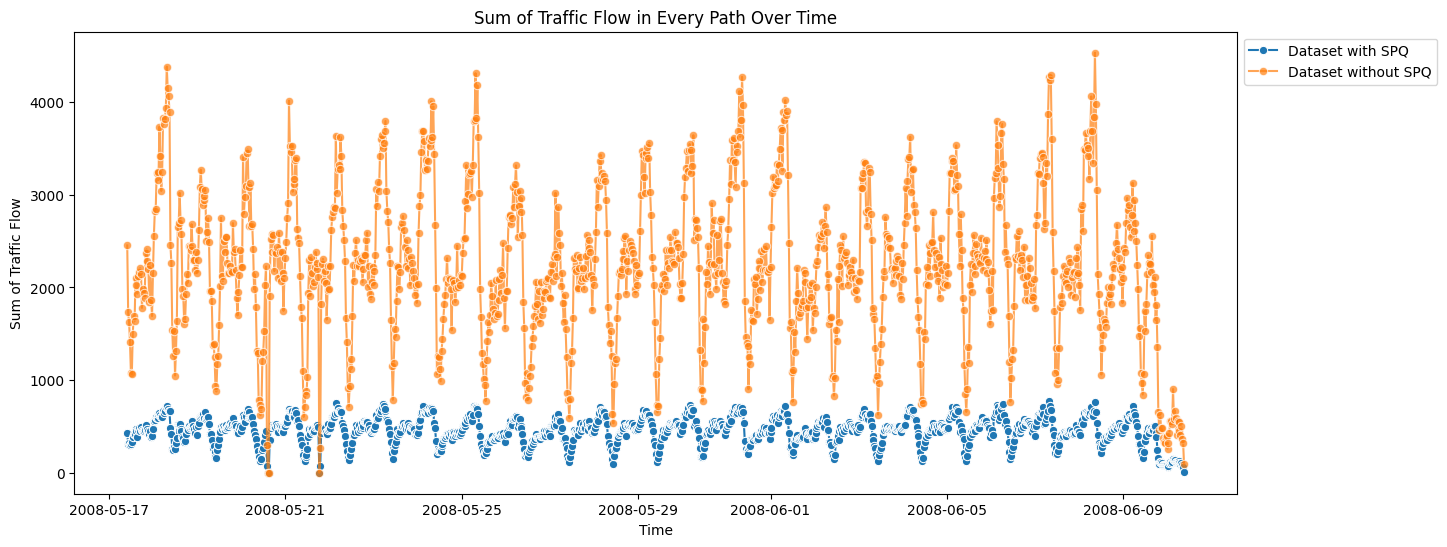

In [29]:
# Create a plot to visualize the results
plt.figure(figsize=(15, 6))

# Plot the sum of traffic flow over time for 'sum_grouped_df_SPQ' dataset
sns.lineplot(data=sum_grouped_df_SPQ, x=sum_grouped_df_SPQ.index, y='Traffic Flow', marker='o', linewidth=1.5, label='Dataset with SPQ')

# Plot the sum of traffic flow over time for 'sum_grouped_df_no_SPQ' dataset
sns.lineplot(data=sum_grouped_df_no_SPQ, x=sum_grouped_df_no_SPQ.index, y='Traffic Flow', marker='o', linewidth=1.5, alpha=0.7, label='Dataset without SPQ')

# Set the labels for the x-axis and y-axis
plt.xlabel('Time')
plt.ylabel('Sum of Traffic Flow')

# Set the title for the plot
plt.title('Sum of Traffic Flow in Every Path Over Time')

# Add a legend to distinguish between the two datasets
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Display the plot
plt.show()

The code below creates a plot to visualize the mean of traffic flow per timestamp

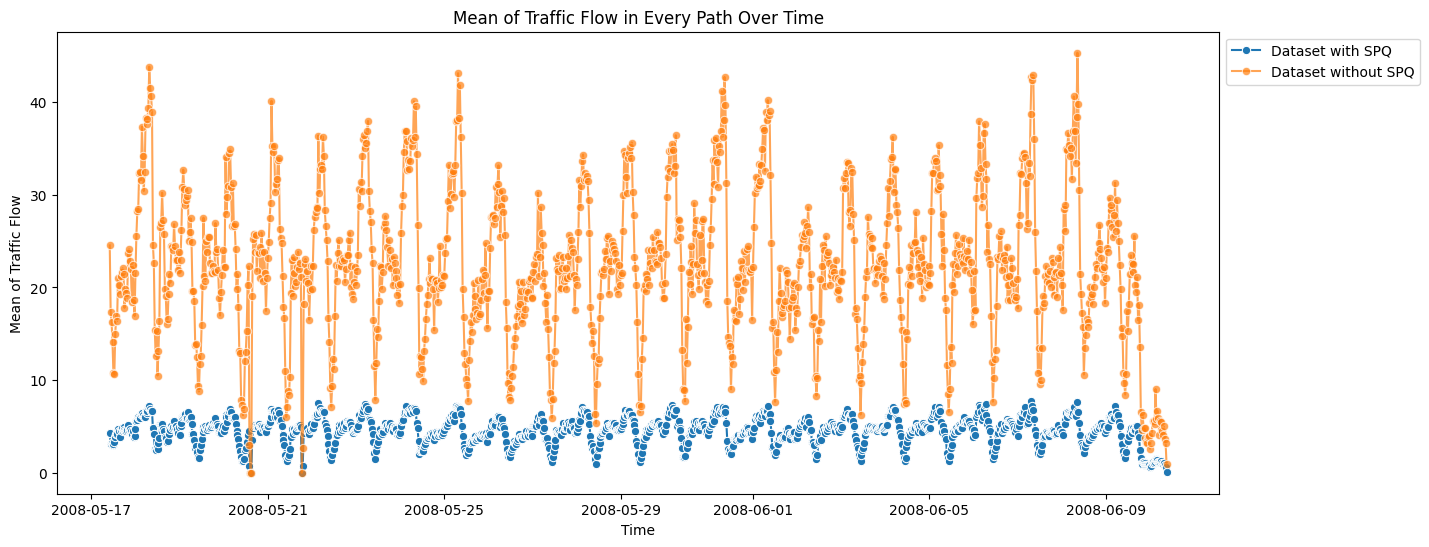

In [30]:
# Create a plot to visualize the results
plt.figure(figsize=(15, 6))

# Plot the sum of traffic flow over time for 'avg_grouped_df_SPQ' dataset
sns.lineplot(data=avg_grouped_df_SPQ, x=avg_grouped_df_SPQ.index, y='Traffic Flow', marker='o', linewidth=1.5, label='Dataset with SPQ')

# Plot the sum of traffic flow over time for 'avg_grouped_df_no_SPQ' dataset
sns.lineplot(data=avg_grouped_df_no_SPQ, x=avg_grouped_df_no_SPQ.index, y='Traffic Flow', marker='o', linewidth=1.5, alpha=0.7, label='Dataset without SPQ')

# Set the labels for the x-axis and y-axis
plt.xlabel('Time')
plt.ylabel('Mean of Traffic Flow')

# Set the title for the plot
plt.title('Mean of Traffic Flow in Every Path Over Time')

# Add a legend to distinguish between the two datasets
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Display the plot
plt.show()